# Imports

In [ ]:
import keras
import numpy as np 
import pandas as pd 
import zipfile
import matplotlib.pyplot as plt
import os
import shutil

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import VGG16, DenseNet201
from keras import models
from keras import layers
from keras import optimizers

# Working with files

In [ ]:
with zipfile.ZipFile("../input/dogs-vs-cats/train.zip", 'r') as zip_ref:
                zip_ref.extractall("./")

with zipfile.ZipFile("../input/dogs-vs-cats/test1.zip", 'r') as zip_ref:
                zip_ref.extractall("./")

Let's see how many photos there are

In [ ]:
print("Total train images")
print(len([f for f in os.listdir('./train') if os.path.isfile(os.path.join('./train', f))]))
print("Total test images")
print(len([f for f in os.listdir('./test1') if os.path.isfile(os.path.join('./test1', f))]))

print("Total train cats images")
print(len([f for f in os.listdir('./train') if os.path.isfile(os.path.join('./train', f)) and 'cat' in f]))
print("Total train dogs images")
print(len([f for f in os.listdir('./train') if os.path.isfile(os.path.join('./train', f)) and 'dog' in f]))

print("Total test cats images")
print(len([f for f in os.listdir('./test1') if os.path.isfile(os.path.join('./test1', f)) and 'cat' in f]))
print("Total test dogs images")
print(len([f for f in os.listdir('./test1') if os.path.isfile(os.path.join('./test1', f)) and 'dog' in f]))

Sample photos

In [ ]:
i = 0
for dirname, _, filenames in os.walk('./train'):
    for filename in filenames:
        print(os.path.join(filename))
        img = plt.imread(os.path.join(dirname, filename))
        print(img.shape)
        plt.figure(i)
        plt.imshow(img)
        i+=1
        if i==7:
            break

Let's create 3 folders for training, testing and testing. We cannot take the test1 folder for testing, since the names of the files are number there.

In [ ]:
base_dir = './'

train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)
test_dir = os.path.join(base_dir, 'test_dir')
os.mkdir(test_dir)

train_cats = os.path.join(train_dir, 'cats')
os.mkdir(train_cats) 
train_dogs = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs)

val_cats = os.path.join(val_dir, 'cats')
os.mkdir(val_cats) 
val_dogs = os.path.join(val_dir, 'dogs')
os.mkdir(val_dogs)

test_cats = os.path.join(test_dir, 'cats')
os.mkdir(test_cats) 
test_dogs = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs)

Our models will be trained on a small amount of data so as not to waste a lot of time. 
Copying files to created dirs

In [ ]:
files = ['cat.{}.jpg'.format(i) for i in range(2000)]
for filename in files:
    src = os.path.join('./train', filename)
    dst = os.path.join(train_cats, filename)
    shutil.copyfile(src, dst)
    
files = ['cat.{}.jpg'.format(i) for i in range(2000, 3000)]
for filename in files:
    src = os.path.join('./train', filename)
    dst = os.path.join(val_cats, filename)
    shutil.copyfile(src, dst)
    
files = ['cat.{}.jpg'.format(i) for i in range(3000, 4000)]
for filename in files:
    src = os.path.join('./train', filename)
    dst = os.path.join(test_cats, filename)
    shutil.copyfile(src, dst)
    
files = ['dog.{}.jpg'.format(i) for i in range(2000)]
for filename in files:
    src = os.path.join('./train', filename)
    dst = os.path.join(train_dogs, filename)
    shutil.copyfile(src, dst)

files = ['dog.{}.jpg'.format(i) for i in range(2000, 3000)]
for filename in files:
    src = os.path.join('./train', filename)
    dst = os.path.join(val_dogs, filename)
    shutil.copyfile(src, dst)
    
files = ['dog.{}.jpg'.format(i) for i in range(3000, 4000)]
for filename in files:
    src = os.path.join('./train', filename)
    dst = os.path.join(test_dogs, filename)
    shutil.copyfile(src, dst)

In [ ]:
print('Train cats: ', len(os.listdir(train_cats)))
print('Train dogs: ', len(os.listdir(train_dogs)))

# Data preprocessing

Prepare data for the VGG16 model.

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)
IMAGE_SIZE=(150,150)
BATCH_SIZE=64
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode='binary')   

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode='binary')   

In [ ]:
for data_batch, labels_batch in train_generator:
    print('Data batch shape:', data_batch.shape)
    print('Labels batch shape:', labels_batch.shape)
    break;

# VGG16 Model

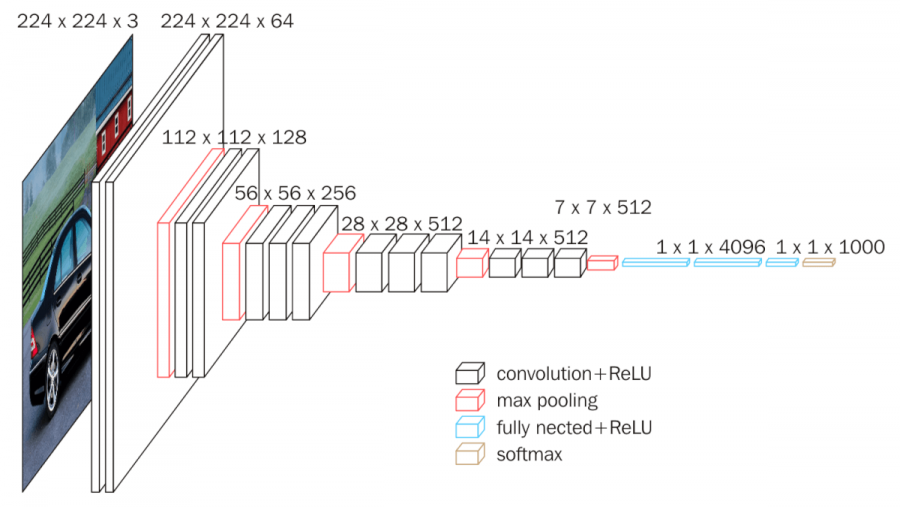

In [ ]:
conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

In [ ]:
conv_base.summary()

Freeze the layers

In [ ]:
conv_base.trainable = False

Let's add our own fully connected classifier

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

In [ ]:
model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])

Adding callbacks

In [ ]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor='acc',
    patience=1),
    keras.callbacks.ModelCheckpoint(
    filepath='vgg16_standart.h5',
    monitor='loss',
    svae_best_only=True)
]

# Training

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=train_generator.n//BATCH_SIZE,
    validation_steps=val_generator.n//BATCH_SIZE,
    epochs = 10,
    callbacks = callbacks_list)

In [ ]:
acc = history.history['acc']
val_acc=history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'o', label='Training accuracy')
plt.plot(epochs, val_acc, 'bo', label='Validation accuracy')

plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'o', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training loss')
plt.legend()

plt.show()

# Testing on test data

Preparing test data

In [ ]:
test_generator = datagen.flow_from_directory(
    test_dir, 
    class_mode='binary',
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE,
    shuffle=False)

In [ ]:
test_acc, test_loss = model.evaluate_generator(test_generator, steps=test_generator.n//BATCH_SIZE)
print('test acc:', test_acc)
print('test loss:', test_loss)

here I reversed, at the beginning of the loss, and then the accuracy

# Data augmentation

We will perform turns, reversals, displacements of pictures

In [ ]:
train_datagen = ImageDataGenerator(
    zoom_range = 0.2,
    horizontal_flip = True,
    rotation_range = 30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2,
    rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode='binary')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode='binary') 

In [ ]:
img = image.load_img('./train/cat.1666.jpg', target_size=(150,150))
x=image.img_to_array(img)
x=x.reshape((1,) + x.shape)

i=0 
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot=plt.imshow(image.array_to_img(batch[0]))
    i+=1
    if i%6==0:
        break
plt.show()

# Fine tuning

Freeze the layers from the 5th, last block. It is best to take these blocks, since the initial blocks encode more generalized features, and higher values ​​encode features. We will not take more blocks so that there is no retraining.

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

In [ ]:
model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])

In [ ]:
model.summary()

In [ ]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor='acc',
    patience=1),
    keras.callbacks.ModelCheckpoint(
    filepath='vgg16_tuned.h5',
    monitor='loss',
    svae_best_only=True)
]

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=train_generator.n//BATCH_SIZE,
    validation_steps=val_generator.n//BATCH_SIZE,
    epochs = 20,
    callbacks = callbacks_list)

In [ ]:
acc = history.history['acc']
val_acc=history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'o', label='Training accuracy')
plt.plot(epochs, val_acc, 'bo', label='Validation accuracy')

plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'o', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
test_acc, test_loss = model.evaluate_generator(test_generator, steps=test_generator.n//BATCH_SIZE)
print('test acc:', test_acc)
print('test loss:', test_loss)

here I reversed, at the beginning of the loss, and then the accuracy

After additional training and augmentation, the accuracy has increased

# DenseNet201

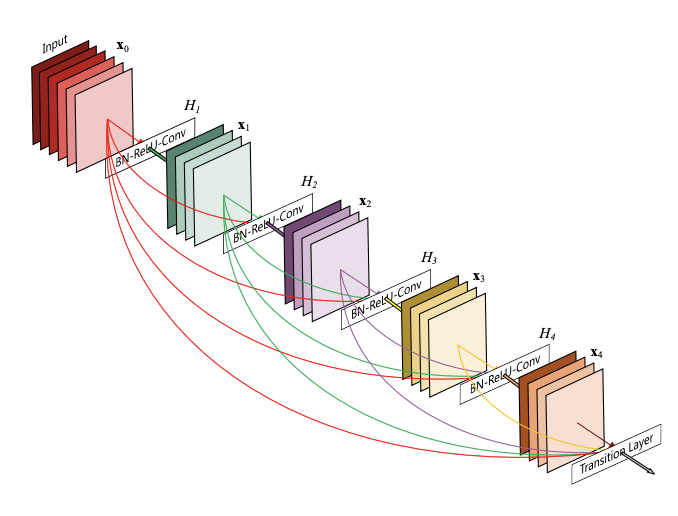

I will try using DenseNet, as I have already worked with it, and it showed excellent accuracy.

I will also use data augmented dataset and finetuning

*Without fine-tuning on augmented dataset*

In [ ]:
conv_base = DenseNet201(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

conv_base.trainable=False
        
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])

In [ ]:
model.summary()

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=train_generator.n//BATCH_SIZE,
    validation_steps=val_generator.n//BATCH_SIZE,
    epochs = 10,
    callbacks = callbacks_list)

In [ ]:
acc = history.history['acc']
val_acc=history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'o', label='Training accuracy')
plt.plot(epochs, val_acc, 'bo', label='Validation accuracy')

plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'o', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=test_generator.n//BATCH_SIZE)
print('test acc:', test_acc)
print('test loss:', test_loss)

here I reversed, at the beginning of the loss, and then the accuracy

*with fine-tuning*

In [ ]:
conv_base.trainable=False

for layer in conv_base.layers[:-10]:
    layer.trainable = False

In [ ]:
model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])

In [ ]:
model.summary()

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=train_generator.n//BATCH_SIZE,
    validation_steps=val_generator.n//BATCH_SIZE,
    epochs = 20,
    callbacks = callbacks_list)

In [ ]:
acc = history.history['acc']
val_acc=history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'o', label='Training accuracy')
plt.plot(epochs, val_acc, 'bo', label='Validation accuracy')

plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'o', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=test_generator.n//BATCH_SIZE)
print('test acc:', test_acc)
print('test loss:', test_loss)

DenseNet performed better than VGG16